In [4]:
# !pip install pandas
# jupyter nbconvert --to script get_tiled_data_from_tiff_hdf5.ipynb

In [1]:
import os
import json
import time
import pandas as pd
import datetime
import rasterio
from matplotlib import pyplot as plt
import numpy as np
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
from os import path
import h5py
import geopy.distance
from rasterio.windows import Window, bounds as r_bounds

ModuleNotFoundError: No module named 'pandas'

In [2]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive

gauth = GoogleAuth()
# Try to load saved client credentials
gauth.LoadCredentialsFile("mycreds.txt")
if gauth.credentials is None:
    # Authenticate if they're not there
    gauth.LocalWebserverAuth()
elif gauth.access_token_expired:
    # Refresh them if expired
    gauth.Refresh()
else:
    # Initialize the saved creds
    gauth.Authorize()
# Save the current credentials to a file
gauth.SaveCredentialsFile("mycreds.txt")

drive = GoogleDrive(gauth)

In [3]:
local_testing_mode = True

# set params
tile_height, tile_length = (64, 64)
examples_per_save_file = 1000
composite_file_name = 'bangladesh_all_bands_final'
download_all_first = not local_testing_mode
offset_px = 20
offset_configs = [(0, 0), (offset_px, 0), (0, offset_px), (offset_px, offset_px)]

save_path = '/atlas/u/mliu356/data/kiln-scaling/final_tiles_indices/'
composite_save_path = '/atlas/u/mliu356/data/kiln-scaling/composites/'

if local_testing_mode:
    save_path = '../data/tiles_testing1/'
    composite_save_path = '../data/composites/'

# resources
kilns = pd.read_csv("../data/bangladesh_kilns.csv")
all_bands = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8A', 'B8', 'B9', 'B10', 'B11', 'B12']

print(kilns.head())

   index        lat        lon     x    y      prob prediction   shape
0      0  23.796287  90.316715  1043  518  0.564438     zigzag  zigzag
1      1  23.940202  90.043026    78  149  0.692853     zigzag  zigzag
2      2  25.021253  89.309124   636  327  0.499505        fck     fck
3      3  25.308184  89.550603    97   85  0.342437        fck  zigzag
4      4  22.561670  92.007151   145  175  0.922128     zigzag  zigzag


In [4]:
def mkdirs(names):
    for name in names:
        if not os.path.exists(name):
            os.makedirs(name)
mkdirs([save_path, composite_save_path])

In [5]:
file_list = drive.ListFile({'q': "title contains '" + composite_file_name + "'"}).GetList()
print("Found " + str(len(file_list)) + " files")
file_list = sorted(file_list, key=lambda file: file['title'])
for file in file_list[:5]:
  print('title: %s, id: %s' % (file['title'], file['id']))

Found 80 files
title: bangladesh_all_bands_final-0000000000-0000000000.tif, id: 1ZHtyKejLTVvFo5s1Ui--sA_RqKBtfZlZ
title: bangladesh_all_bands_final-0000000000-0000006656.tif, id: 1GlKU0_kZEaisJ8sBWGsl7VNg9pwsPD8Z
title: bangladesh_all_bands_final-0000000000-0000013312.tif, id: 1Wm1kJeH2zQ42bNEuqDbSLcR_vP-KEu6_
title: bangladesh_all_bands_final-0000000000-0000019968.tif, id: 1RkLg2pzmr9QkVg8NmfPhKVbPGAtxkfKH
title: bangladesh_all_bands_final-0000000000-0000026624.tif, id: 1YCQxQ6WzZQTwpEKY7IeW1lWbCBYcUN2l


In [6]:
# calculate image grid
first_x_coord = file_list[0]['title'].split(".")[0].split("-")[1]
first_y_coord = file_list[0]['title'].split(".")[0].split("-")[2]
num_image_cols = len([x for x in file_list if x['title'].split(".")[0].split("-")[1] == first_x_coord])
num_image_rows = len([x for x in file_list if x['title'].split(".")[0].split("-")[2] == first_y_coord])
print("Number of image grid columns:", num_image_cols)
print("Number of image grid rows:", num_image_rows)

Number of image grid columns: 8
Number of image grid rows: 10


In [7]:
coords = []
with open("../data/countries.geojson", "r") as countries_geojson:
    country_dict = json.load(countries_geojson)["features"]
for obj in country_dict:
    name = obj['properties']['ADMIN']
    if name == "Bangladesh":
        coords = obj['geometry']["coordinates"]
flat_coords = []
for sublist in coords:
    for coord in sublist:
        for c in coord:
            flat_coords.append(c)
            
flat_coords += [flat_coords[0]]
bangladesh_geo = Polygon(flat_coords)

In [8]:
# optional pre-download all files
if download_all_first:
    for file in file_list:
        start_time = time.time()
        composite_file_path = composite_save_path + file['title']
        if path.exists(composite_file_path):
            print("File already downloaded.", composite_file_path)
        else:
            print("Downloading file...")
            # download the file
            download_file = drive.CreateFile({'id': file['id']})
            file.GetContentFile(composite_file_path)
            print("Finished file in " + str(time.time() - start_time))
    print("Done downloading all files.")

In [9]:
def get_tile_info_from_px(dataset, px_row, px_col, has_kiln):
    global num_tiles_dropped
    global pos_examples_data, pos_examples_bounds
    global test_ex_data, test_ex_bounds
    
    window = Window(px_col, px_row, tile_length, tile_height)
    bands = dataset.read(window=window)
    bounds = list(r_bounds(window, dataset.transform))
    tile_geo = Polygon([[bounds[0], bounds[2]], [bounds[0], bounds[3]], [bounds[1], bounds[3]], [bounds[1], bounds[2]], [bounds[0], bounds[2]]])
    
    if has_kiln or bangladesh_geo.intersects(tile_geo):
        return bands, bounds
    else:
        return None, None
    
def get_tile_has_kiln(dataset, px_row, px_col):
    window = Window(px_col, px_row, tile_length, tile_height)
    bounds = list(r_bounds(window, dataset.transform))
    kilns_in_image = kilns.loc[(kilns['lat'] >= bounds[1]) & (kilns['lat'] <= bounds[3]) 
        & (kilns['lon'] >= bounds[0]) & (kilns['lon'] <= bounds[2])]

    return len(kilns_in_image) >= 1

In [10]:
def save_current_file(save_index, counter):
    filename = save_path + "examples_" + str(save_index) + ".hdf5"
    print("Saving file", filename)
    f = h5py.File(filename, 'w')
    bounds_dset = f.create_dataset("bounds", data=tile_bounds[:counter])
    examples_dset = f.create_dataset("images", data=examples[:counter])
    labels_dset = f.create_dataset("labels", data=labels[:counter])
    indices_dset = f.create_dataset("indices", data=tile_indices[:counter])
    f.close()
    return save_index + 1, 0

def add_example(ex_data, ex_bounds, t_global_indices, save_index, counter, is_positive):
    tile_bounds[counter] = ex_bounds
    examples[counter] = ex_data
    labels[counter] = 1 if is_positive else 0
    tile_indices[counter] = t_global_indices
    new_counter = counter + 1
    
    if new_counter == examples_per_save_file:
        return save_current_file(save_index, counter)
    return save_index, new_counter

In [11]:
## testing & visualization methods

# image is a single example of shape (13, 64, 64)
def visualize_tile(image, indices=[3, 2, 1]):
    row_idx = np.array(indices)
    X = np.transpose(image[row_idx], (1, 2, 0))
    X *= 1 / np.max(X)
    print(X.shape)
    plt.imshow(X)
    
def pretty_bounds(bounds):
    return [[bounds[0], bounds[1]], [bounds[2], bounds[1]], [bounds[2], bounds[3]], [bounds[0], bounds[3]], [bounds[0], bounds[1]]]

In [12]:
## testing variables
num_tiles_dropped = 0
pos_examples_data = []
pos_examples_bounds = []
test_ex_data = []
test_ex_bounds = []

save_index, counter = 0, 0

tile_bounds = np.zeros([examples_per_save_file, 4]) # [left, bottom, right, top]
examples = np.zeros([examples_per_save_file, len(all_bands), tile_height, tile_length])
labels = np.zeros([examples_per_save_file, 1])
tile_indices = np.zeros([examples_per_save_file, 3]) # [row, col, offset_index]

In [15]:
if local_testing_mode:
    file_list = file_list[:1]

std_tile_rows, std_tile_cols = None, None
    
total_start_time = time.time()
for index, file in enumerate(file_list):
    file_start_time = time.time()
    print("Starting file " + file['title'])
    
    # get composite image indices
    c_row = int(index / num_image_rows)
    c_col = index % num_image_rows
    
    composite_file_path = composite_save_path + file['title']
    if not path.exists(composite_file_path):
        print("Downloading file...")
        # download the file
        download_file = drive.CreateFile({'id': file['id']})
        file.GetContentFile(composite_file_path)
    dataset = rasterio.open(composite_file_path)
    
    for offset_index, offset_config in enumerate(offset_configs):
        num_rows = int((dataset.height - offset_config[0]) / tile_height)
        num_cols = int((dataset.width - offset_config[1]) / tile_length)
        
        if std_tile_rows is None:
            std_tile_rows = num_rows
            std_tile_cols = num_cols
        
        # first pass to calculate kiln_tiles
        kiln_tiles = []
        for tile_idx_row in range(0, num_rows):
            px_row = tile_idx_row * tile_height + offset_config[0]
            for tile_idx_col in range(0, num_cols):
                px_col = tile_idx_col * tile_length + offset_config[1]
                if get_tile_has_kiln(dataset, px_row, px_col):
                    kiln_tiles += [(tile_idx_row, tile_idx_col)]
        
        # only calculate drop_tiles for first offset 
        # (for all other offsets, no negative examples are saved anyways)
        drop_tiles = []
        if offset_index == 0:
            for row_index, col_index in kiln_tiles:
                neighbors = [(row_index - 1, col_index - 1), (row_index, col_index - 1), (row_index + 1, col_index - 1), 
                             (row_index - 1, col_index), (row_index + 1, col_index), 
                             (row_index - 1, col_index + 1), (row_index, col_index + 1), (row_index + 1, col_index + 1)]
                for n in neighbors:
                    if n not in kiln_tiles and n[0] >= 0 and n[0] < num_rows and n[1] >= 0 and n[1] < num_cols:
                        drop_tiles += [n]
        
        # second pass to calculate and save data
        for tile_idx_row in range(0, num_rows):
            px_row = tile_idx_row * tile_height + offset_config[0]
            for tile_idx_col in range(0, num_cols):
                px_col = tile_idx_col * tile_length + offset_config[1]
                tile_has_kiln = (tile_idx_row, tile_idx_col) in kiln_tiles
                t_data, t_bounds = None, None
                if tile_has_kiln or offset_index == 0:
                    t_data, t_bounds = get_tile_info_from_px(dataset, px_row, px_col, tile_has_kiln)
                
                # save data only if:
                # (1) tile is a kiln OR
                # (2a) t_data is not None (first offset and tile in country)
                # (2b) tile is not a neighbor of a kiln
                tile_is_drop = (tile_idx_row, tile_idx_col) in drop_tiles
                if tile_has_kiln or (t_data is not None and not tile_is_drop):
                    t_global_row = c_row * std_tile_rows + tile_idx_row
                    t_global_col = c_col * std_tile_cols + tile_idx_col
                    t_global_indices = [t_global_row, t_global_col, offset_index]
                    
                    save_index, counter = add_example(t_data, t_bounds, t_global_indices, save_index, counter, tile_has_kiln)
                    
    # handle leftovers in a final file
    if index == len(file_list) - 1:
        save_current_file(save_index, counter)

    print("Total tiles dropped (outside country):", num_tiles_dropped)
    print("Total tiles kept:", str(num_rows * num_cols * len(offset_configs) - num_tiles_dropped))
    num_tiles_dropped = 0
    print("Finished file in", time.time() - file_start_time, "\n")
print("Finished " + str(len(file_list)) + " files in: " + str(time.time() - total_start_time))

Starting file bangladesh_all_bands_final-0000000000-0000000000.tif
Kiln tiles: [(67, 58), (71, 90), (71, 91), (78, 60), (91, 45), (95, 75), (97, 76), (98, 76), (98, 78), (99, 72), (99, 73)]
Drop tiles: [(66, 57), (67, 57), (68, 57), (66, 58), (68, 58), (66, 59), (67, 59), (68, 59), (70, 89), (71, 89), (72, 89), (70, 90), (72, 90), (70, 91), (72, 91), (70, 90), (72, 90), (70, 91), (72, 91), (70, 92), (71, 92), (72, 92), (77, 59), (78, 59), (79, 59), (77, 60), (79, 60), (77, 61), (78, 61), (79, 61), (90, 44), (91, 44), (92, 44), (90, 45), (92, 45), (90, 46), (91, 46), (92, 46), (94, 74), (95, 74), (96, 74), (94, 75), (96, 75), (94, 76), (95, 76), (96, 76), (96, 75), (97, 75), (98, 75), (96, 76), (96, 77), (97, 77), (98, 77), (97, 75), (98, 75), (99, 75), (99, 76), (97, 77), (98, 77), (99, 77), (97, 77), (98, 77), (99, 77), (97, 78), (99, 78), (97, 79), (98, 79), (99, 79), (98, 71), (99, 71), (100, 71), (98, 72), (100, 72), (98, 73), (100, 73), (98, 72), (100, 72), (98, 73), (100, 73), (9

KeyboardInterrupt: 

## Test hdf5 file data format & visualizations

In [83]:
print(pretty_bounds([dataset.bounds.left, dataset.bounds.bottom, dataset.bounds.right, dataset.bounds.top]))

[[88.02178244056496, 26.02563108539713],
 [88.61970109367492, 26.02563108539713],
 [88.61970109367492, 26.623549738507084],
 [88.02178244056496, 26.623549738507084],
 [88.02178244056496, 26.02563108539713]]

4
(64, 64, 3)


[[88.54496126203617, 26.209606055584807],
 [88.55071047985453, 26.209606055584807],
 [88.55071047985453, 26.215355273403173],
 [88.54496126203617, 26.215355273403173],
 [88.54496126203617, 26.209606055584807]]

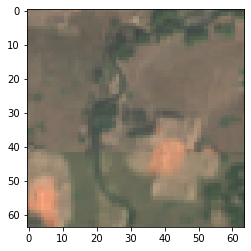

In [119]:
# print(len(pos_examples_bounds))
# vis_index = 2

# visualize_tile(pos_examples_data[vis_index])
# pretty_bounds(pos_examples_bounds[vis_index])

In [27]:
# print("Examples w/ kilns:", np.where(labels==1.0)[0])
# index = 4321
# print("label:", y[index])
# vis_X = X[index]
# vis_X *= 1 / np.max(vis_X)
# print(vis_X.shape)
# plt.imshow(vis_X)

Examples w/ kilns: [40 41 42]
